In [9]:
import pylab as pl
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [10]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [11]:
X = lfw_people.data
n_features = X.shape[1] 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)

In [13]:
n_components = 50
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)

In [14]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)


In [16]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.66      0.59      0.62        59
  Donald Rumsfeld       0.46      0.35      0.40        34
    George W Bush       0.66      0.85      0.74       125
Gerhard Schroeder       0.62      0.60      0.61        30
      Hugo Chavez       0.57      0.20      0.30        20
       Tony Blair       0.52      0.44      0.47        32

         accuracy                           0.63       322
        macro avg       0.60      0.52      0.55       322
     weighted avg       0.62      0.63      0.61       322



In [17]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

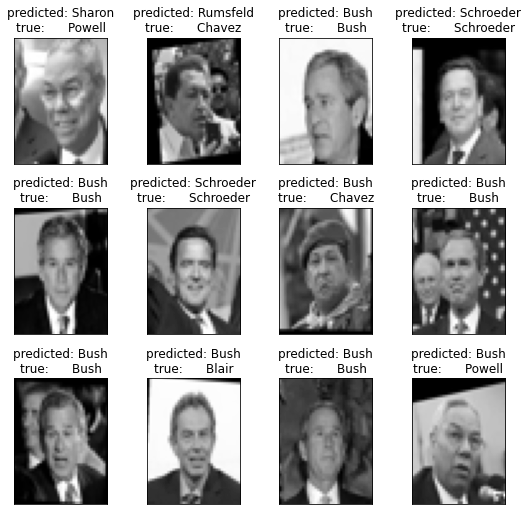

In [19]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)